In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Proyecto de Optimización Numérica I

- Samuel Elí Méndez Sánchez 196659
- Santiago Casanova Díaz 189756
- Eduardo Mateo Guajardo Rodriguez 166273
- Sebastian Ibarra Del Corral 193992
- Sandra Reyes Benavides 179149

In [6]:
iris = pd.read_csv("Iris.csv")
iris

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


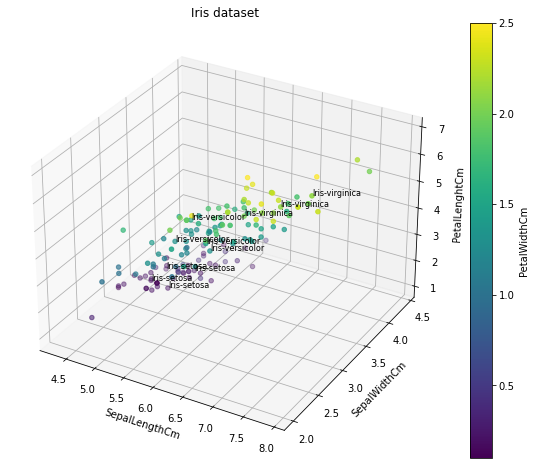

In [10]:
n = 149
x = iris["SepalLengthCm"]
y = iris["SepalWidthCm"]
z = iris["PetalLengthCm"]
c = iris["PetalWidthCm"]
species = iris["Species"]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, c=c, cmap='viridis')

plt.colorbar(scatter, label='PetalWidthCm')

ax.set_xlabel('SepalLengthCm')
ax.set_ylabel('SepalWidthCm')
ax.set_zlabel('PetalLenghtCm')

plt.title("Iris dataset", loc='center')

for i in range(n):
    if(np.random.rand()<0.1):
        ax.text(x[i], y[i], z[i], species[i], color='black', fontsize=8)

plt.show()



In [11]:
#Separamos primero los conjuntos: 
A = iris[iris["Species"]=="Iris-setosa"]
B = iris[iris["Species"]=="Iris-virginica"]
C = iris[iris["Species"]=="Iris-versicolor"]

In [12]:
A_mat = A[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]].values
B_mat = B[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]].values
C_mat = C[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]].values
Vec_m1= np.full((50, 1), -1)
Vec_1 = np.full((50, 1), 1)

d = np.full((100, 1), 1)
c = np.full((5,1),0)

array([[0],
       [0],
       [0],
       [0],
       [0]])

# Para el caso de Setosa con Virginica 
### A vs B
La matriz F debe quedar de la forma:

\begin{bmatrix}
[-\text{transposed}(x_i)] & [-1] \\
[\text{transposed}(x_i)] & [1] \\
\end{bmatrix}

\begin{bmatrix}
[-A_{mat}] & [Vec_{m1}] \\
[B] & [Vec_1] \\
\end{bmatrix}


In [13]:
concatenated_matrix_up = np.hstack((-A_mat, Vec_m1))
concatenated_matrix_down = np.hstack((B_mat, Vec_1))
final_matrix = np.vstack((concatenated_matrix_up,concatenated_matrix_down))
F = final_matrix

In [14]:
Q=np.eye(5)
F=final_matrix
print(Q.shape)
print(F.shape)
print(d.shape)
print(c.shape)


(5, 5)
(100, 5)
(100, 1)
(5, 1)


In [15]:
def paso_intpoint(u, v):
    p = len(u)
    v_alfa = np.ones(p)
    for i in range(p):
         if v[i] < 0:
             v_alfa[i] = -u[i] / v[i]
    alfa = min(np.amin(v_alfa), 1.0)        
    return alfa

In [16]:
def myqp_intpoint_modificado(Q, F, c, d):
    n = len(c)
    p = len(d)
    tol = 10**(-5)
    maxiter = 100
    iter = 0
    x = np.ones((n, 1)) # Asegúrate de que x es un vector columna
    mu = np.ones((p, 1)) # Asegúrate de que mu es un vector columna
    z = np.ones((p, 1)) # Asegúrate de que z es un vector columna
    
    while iter < maxiter:
        iter += 1
        # Calcula los componentes de cnpo para esta iteración
        v1 = np.dot(Q, x) - np.dot(F.T, mu) + c
        v3 = -np.dot(F, x) + z + d
        v4 = mu * z # Multiplicación elemento a elemento

        # Usa np.vstack para concatenar verticalmente y formar cnpo correctamente
        cnpo = np.vstack([v1, v3, v4])
        norma_cnpo = np.linalg.norm(cnpo)
        
        if norma_cnpo <= tol:
            break
        
        # Ajustes para preparar la solución del sistema lineal
        M = np.zeros((n + 2*p, n + 2*p))
        M[:n, :n] = Q
        M[:n, n:n+p] = -F.T
        M[n:n+p, :n] = -F
        M[n:n+p, n+p:] = np.eye(p)
        M[n+p:, n:n+p] = np.diagflat(z)
        M[n+p:, n+p:] = np.diagflat(mu)

        # Ajuste el lado derecho del sistema
        cnpo_pert = cnpo.copy()
        cnpo_pert[n+p:] -= 0.5 / p * np.sum(mu * z)
        
        # Resuelve el sistema lineal
        dw = np.linalg.solve(M, -cnpo_pert)
        dx = dw[:n]
        dmu = dw[n:n+p]
        dz = dw[n+p:]

        # Calcula los pasos para mu y z
        alfa1 = paso_intpoint(mu.flatten(), dmu.flatten())
        alfa2 = paso_intpoint(z.flatten(), dz.flatten())
        alfa = 0.95 * min(alfa1, alfa2, 1.0)

        # Actualiza las variables
        x += alfa * dx
        mu += alfa * dmu
        z += alfa * dz

        print("Iteración:", iter, "| Norma de cnpo:", norma_cnpo)

    return x, mu, z, iter

# Nota: Asegúrate de definir Q, F, c, y d antes de llamar a esta función.

In [17]:
(x,mu,z,iter)=myqp_intpoint_modificado(Q, F, c, d)

Iteración: 1 | Norma de cnpo: 278.664098871742
Iteración: 2 | Norma de cnpo: 153.13958951041622
Iteración: 3 | Norma de cnpo: 27.076934863827077
Iteración: 4 | Norma de cnpo: 7.085835078635484
Iteración: 5 | Norma de cnpo: 0.47569061186429107
Iteración: 6 | Norma de cnpo: 0.18520362457706763
Iteración: 7 | Norma de cnpo: 0.10661031962806955
Iteración: 8 | Norma de cnpo: 0.06143395962386659
Iteración: 9 | Norma de cnpo: 0.03517015773273126
Iteración: 10 | Norma de cnpo: 0.02150534441372241
Iteración: 11 | Norma de cnpo: 0.012052610920527325
Iteración: 12 | Norma de cnpo: 0.007889995772773634
Iteración: 13 | Norma de cnpo: 0.004305342886292964
Iteración: 14 | Norma de cnpo: 0.0028019734044991314
Iteración: 15 | Norma de cnpo: 0.0014707940705647635
Iteración: 16 | Norma de cnpo: 0.0007756002657950245
Iteración: 17 | Norma de cnpo: 0.00040838360424472236
Iteración: 18 | Norma de cnpo: 0.00021484293823074928
Iteración: 19 | Norma de cnpo: 0.00011292194335415256
Iteración: 20 | Norma de cnpo

In [18]:
x

array([[-0.26728515],
       [-0.23013789],
       [ 0.60545728],
       [ 0.30023956],
       [-0.14506836]])

#### Grafica con todas las dimensiones

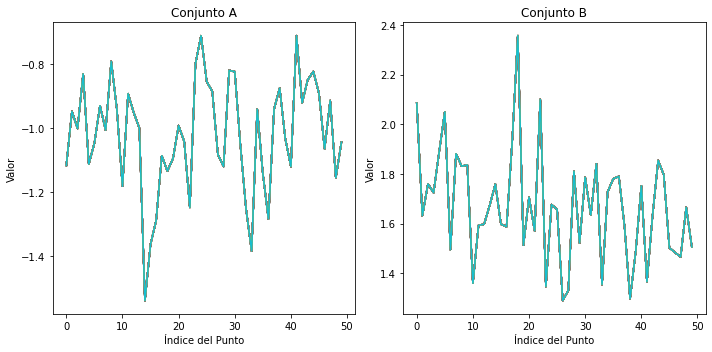

In [19]:
w = x[:-1]  
beta = x[-1] 
A = A_mat
B = B_mat

# Calcula ATw - e y BTw - e
e = np.ones(A.shape[0])
ATw_minus_e = A.dot(w) - e * beta

e = np.ones(B.shape[0])
BTw_minus_e = B.dot(w) - e * beta

# Graficación
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ATw_minus_e, label='ATw - e')
plt.title('Conjunto A')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor')
#plt.legend()

plt.subplot(1, 2, 2)
plt.plot(BTw_minus_e, label='BTw - e')
plt.title('Conjunto B')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor')
#plt.legend()

plt.tight_layout()
plt.show()


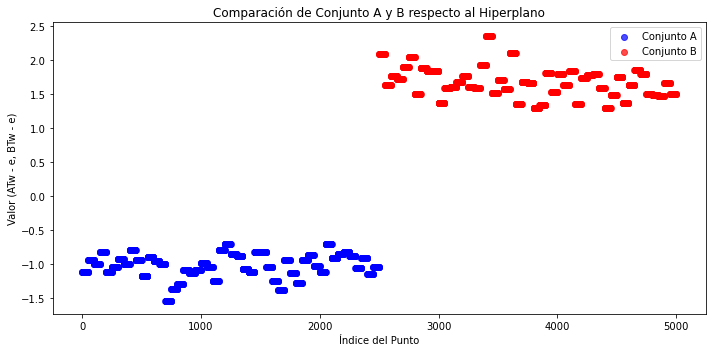

In [20]:
# Asumiendo que w, beta, A_mat, y B_mat están definidos
w = x[:-1]  # vector w
beta = x[-1]  # valor beta
A = A_mat  # matriz A
B = B_mat  # matriz B

# Calcula ATw - e y BTw - e
e_A = np.ones(A.shape[0])
ATw_minus_e = A.dot(w) - e_A * beta

e_B = np.ones(B.shape[0])
BTw_minus_e = B.dot(w) - e_B * beta

# Asegurémonos de que las dimensiones de ATw_minus_e y BTw_minus_e son adecuadas para graficar
# Por claridad, vamos a aplanar los arrays para garantizar que son 1D
ATw_minus_e = ATw_minus_e.flatten()
BTw_minus_e = BTw_minus_e.flatten()

# Graficación en una sola gráfica usando scatter
plt.figure(figsize=(10, 5))

# Aquí no necesitamos generar índices ya que scatter puede manejar los valores directamente
plt.scatter(np.arange(len(ATw_minus_e)), ATw_minus_e, color='blue', label='Conjunto A', alpha=0.7)
plt.scatter(np.arange(len(BTw_minus_e)) + len(ATw_minus_e), BTw_minus_e, color='red', label='Conjunto B', alpha=0.7)

plt.title('Comparación de Conjunto A y B respecto al Hiperplano')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor (ATw - e, BTw - e)')
plt.legend()

plt.tight_layout()
plt.show()

#### Visualización del conjunto

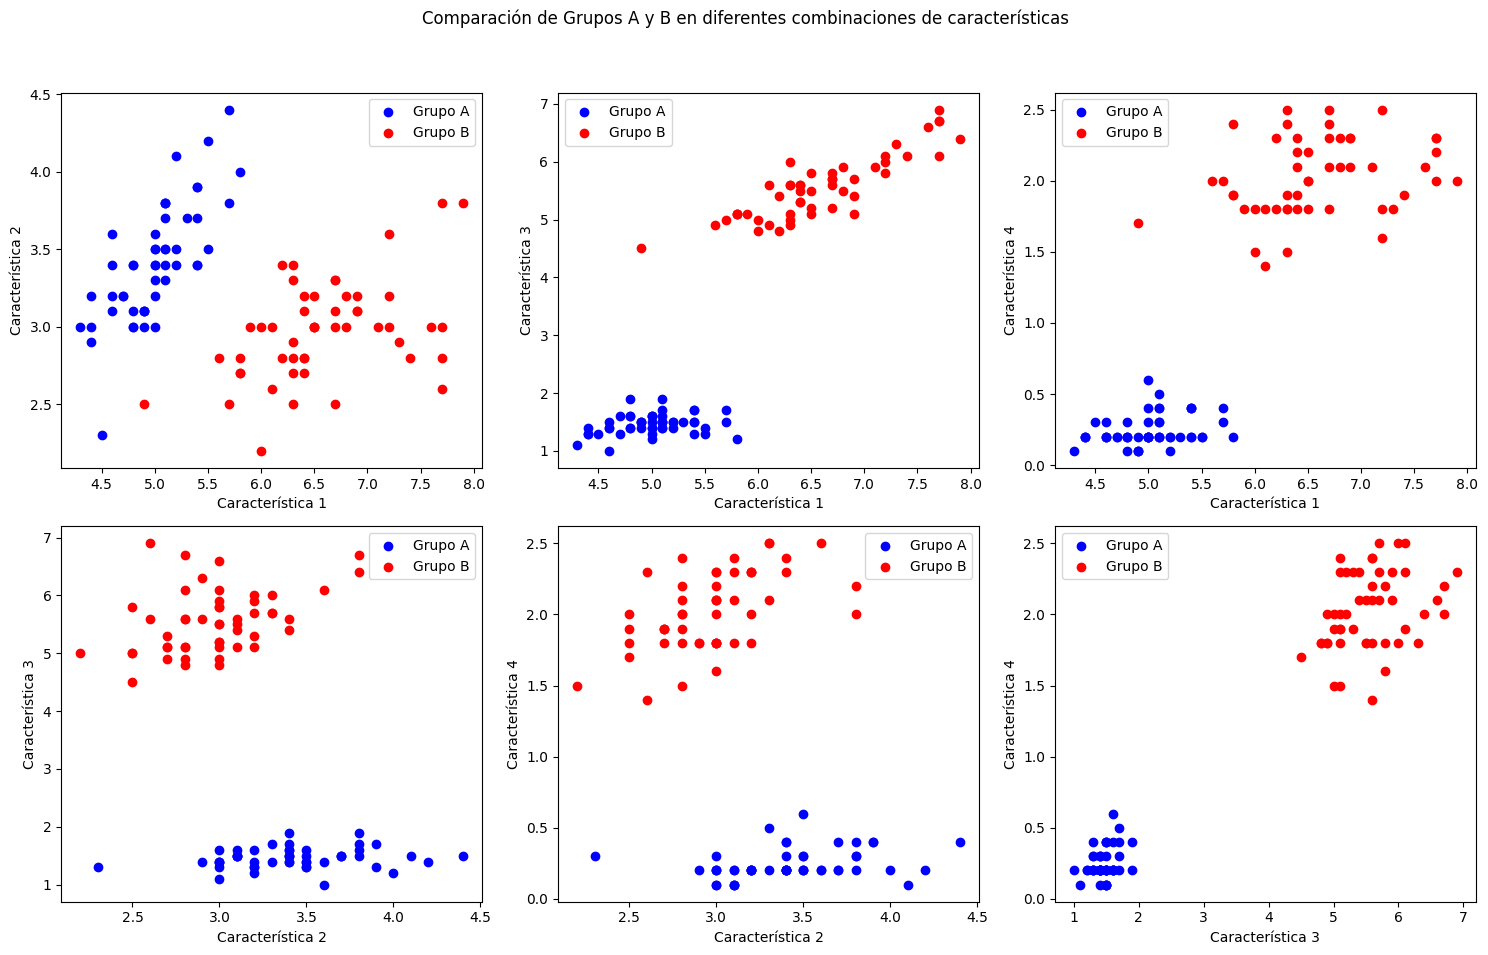

In [16]:
A = A_mat
B = B_mat

w = x[:-1]  
beta = x[-1] 


# Definir las combinaciones de características
combinaciones = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Crear una figura y ejes para las subgráficas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Comparación de Grupos A y B en diferentes combinaciones de características')

for i, (feat1, feat2) in enumerate(combinaciones):
    ax = axes[i//3, i%3]
    # Graficar los puntos de A y B para cada combinación de características
    ax.scatter(A[:, feat1], A[:, feat2], color='blue', label='Grupo A')
    ax.scatter(B[:, feat1], B[:, feat2], color='red', label='Grupo B')
    ax.set_xlabel(f'Característica {feat1+1}')
    ax.set_ylabel(f'Característica {feat2+1}')
    ax.legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Para el caso de Virginica con Versicolor
### A vs C


In [17]:
concatenated_matrix_up = np.hstack((-A_mat, Vec_m1))
concatenated_matrix_down = np.hstack((C_mat, Vec_1))
final_matrix = np.vstack((concatenated_matrix_up,concatenated_matrix_down))
F2 = final_matrix

In [18]:
(x,mu,z,iter)= myqp_intpoint_modificado(Q, F2, c, d)

Iteración: 1 | Norma de cnpo: 207.2205588256146
Iteración: 2 | Norma de cnpo: 118.81354937857414
Iteración: 3 | Norma de cnpo: 24.797009163425578
Iteración: 4 | Norma de cnpo: 5.898760288291389
Iteración: 5 | Norma de cnpo: 0.5194603159629674
Iteración: 6 | Norma de cnpo: 0.24932559125261575
Iteración: 7 | Norma de cnpo: 0.14335068703438997
Iteración: 8 | Norma de cnpo: 0.08876356182863841
Iteración: 9 | Norma de cnpo: 0.06878163948769217
Iteración: 10 | Norma de cnpo: 0.038324999518168944
Iteración: 11 | Norma de cnpo: 0.022546220509598768
Iteración: 12 | Norma de cnpo: 0.012796091009465046
Iteración: 13 | Norma de cnpo: 0.006754934716841806
Iteración: 14 | Norma de cnpo: 0.003562459407399881
Iteración: 15 | Norma de cnpo: 0.0018740356490767435
Iteración: 16 | Norma de cnpo: 0.0009851579520075227
Iteración: 17 | Norma de cnpo: 0.0005175692447177817
Iteración: 18 | Norma de cnpo: 0.000271824727585601
Iteración: 19 | Norma de cnpo: 0.00014273597573087244
Iteración: 20 | Norma de cnpo: 7

In [19]:
x

array([[-0.3094533 ],
       [-0.42972132],
       [ 1.0455132 ],
       [ 0.61780655],
       [-0.16361098]])

#### Grafica con todas las dimensiones

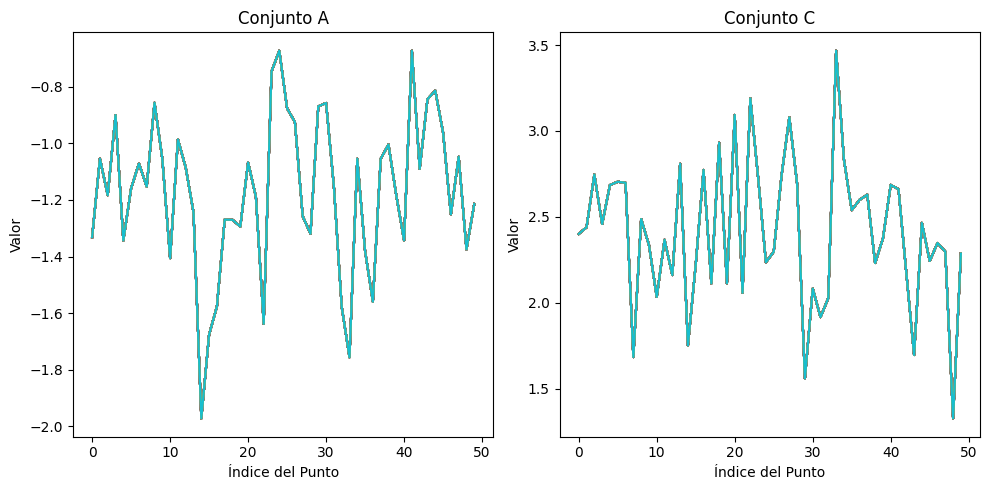

In [20]:
w = x[:-1]  
beta = x[-1] 
A = A_mat
B = C_mat

# Calcula ATw - e y BTw - e
e = np.ones(A.shape[0])
ATw_minus_e = A.dot(w) - e * beta

e = np.ones(B.shape[0])
BTw_minus_e = B.dot(w) - e * beta

# Graficación
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ATw_minus_e, label='ATw - e')
plt.title('Conjunto A')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor')
#plt.legend()

plt.subplot(1, 2, 2)
plt.plot(BTw_minus_e, label='BTw - e')
plt.title('Conjunto C')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor')
#plt.legend()

plt.tight_layout()
plt.show()

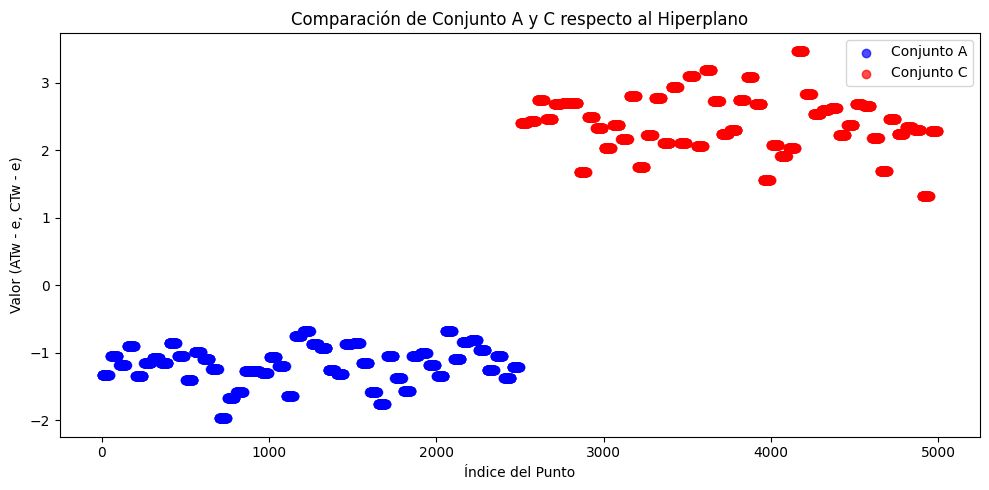

In [21]:
w = x[:-1]  
beta = x[-1] 
A = A_mat
B = C_mat

# Calcula ATw - e y BTw - e
e_A = np.ones(A.shape[0])
ATw_minus_e = A.dot(w) - e_A * beta

e_B = np.ones(B.shape[0])
BTw_minus_e = B.dot(w) - e_B * beta

# Asegurémonos de que las dimensiones de ATw_minus_e y BTw_minus_e son adecuadas para graficar
# Por claridad, vamos a aplanar los arrays para garantizar que son 1D
ATw_minus_e = ATw_minus_e.flatten()
BTw_minus_e = BTw_minus_e.flatten()

# Graficación en una sola gráfica usando scatter
plt.figure(figsize=(10, 5))

# Aquí no necesitamos generar índices ya que scatter puede manejar los valores directamente
plt.scatter(np.arange(len(ATw_minus_e)), ATw_minus_e, color='blue', label='Conjunto A', alpha=0.7)
plt.scatter(np.arange(len(BTw_minus_e)) + len(ATw_minus_e), BTw_minus_e, color='red', label='Conjunto C', alpha=0.7)

plt.title('Comparación de Conjunto A y C respecto al Hiperplano')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor (ATw - e, CTw - e)')
plt.legend()

plt.tight_layout()
plt.show()

#### Visualización del conjunto

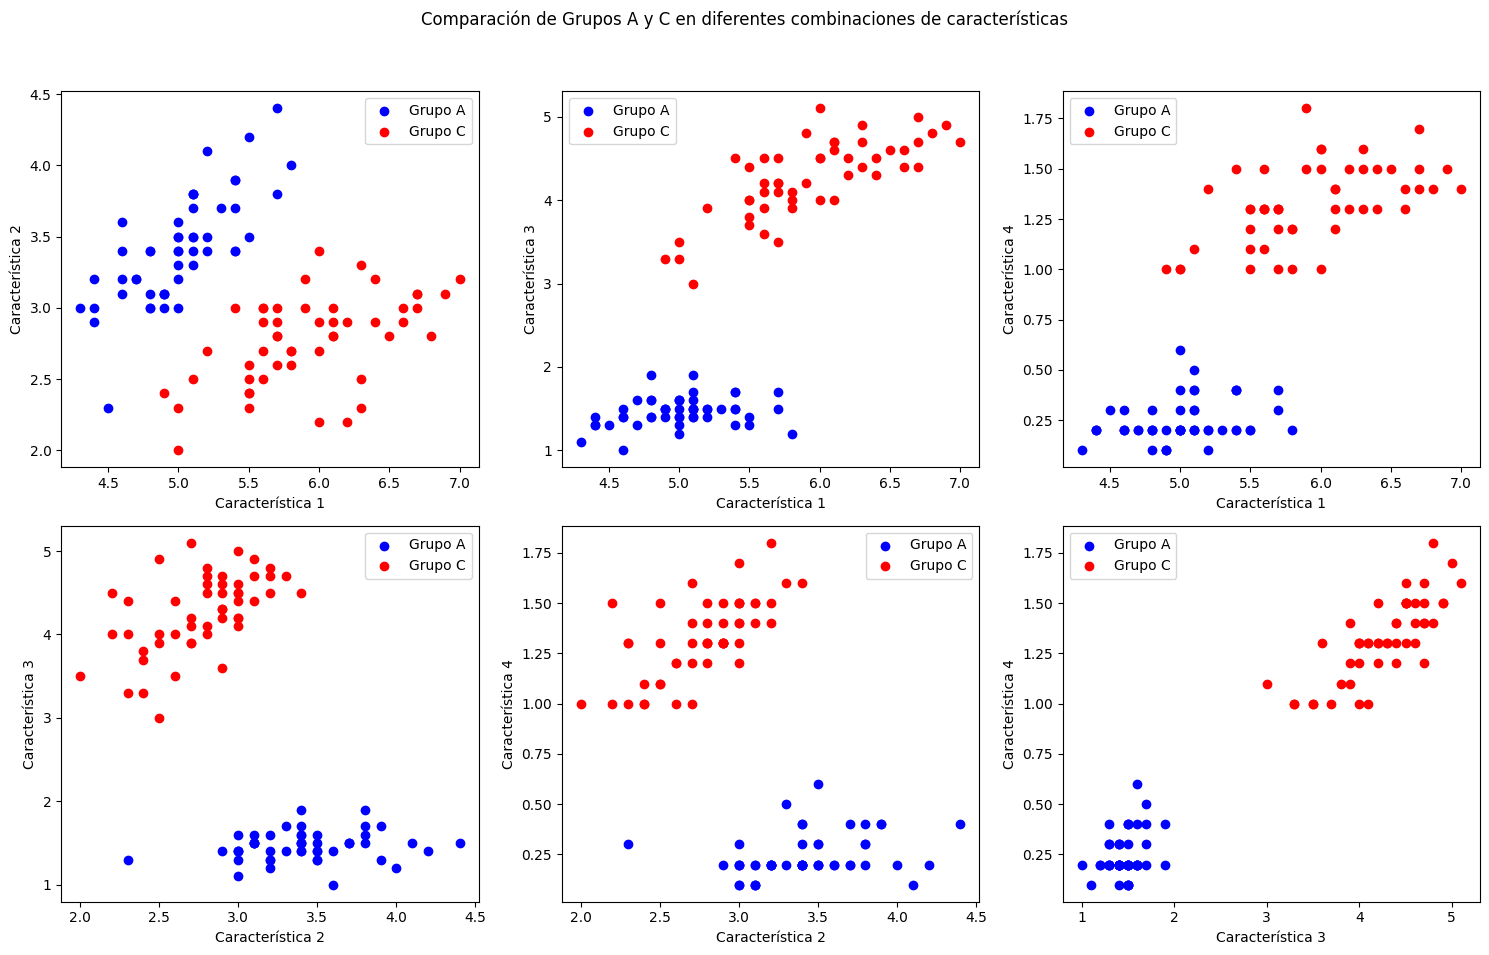

In [22]:
A = A_mat
B = C_mat

w = x[:-1]  
beta = x[-1] 


# Definir las combinaciones de características
combinaciones = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Crear una figura y ejes para las subgráficas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Comparación de Grupos A y C en diferentes combinaciones de características')

for i, (feat1, feat2) in enumerate(combinaciones):
    ax = axes[i//3, i%3]
    # Graficar los puntos de A y B para cada combinación de características
    ax.scatter(A[:, feat1], A[:, feat2], color='blue', label='Grupo A')
    ax.scatter(B[:, feat1], B[:, feat2], color='red', label='Grupo C')
    ax.set_xlabel(f'Característica {feat1+1}')
    ax.set_ylabel(f'Característica {feat2+1}')
    ax.legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Para el caso de Versicolor con Virgilia
### B vs C

In [23]:
concatenated_matrix_up = np.hstack((-B_mat, Vec_m1))
concatenated_matrix_down = np.hstack((C_mat, Vec_1))
final_matrix = np.vstack((concatenated_matrix_up,concatenated_matrix_down))
F3 = final_matrix

In [24]:
(x,mu,z,iter)= myqp_intpoint_modificado(Q, F3, c, d)

Iteración: 1 | Norma de cnpo: 190.40735279920258
Iteración: 2 | Norma de cnpo: 133.52234816082142
Iteración: 3 | Norma de cnpo: 122.76194107043496
Iteración: 4 | Norma de cnpo: 115.51459068778787
Iteración: 5 | Norma de cnpo: 110.65165637240267
Iteración: 6 | Norma de cnpo: 109.32466396882528
Iteración: 7 | Norma de cnpo: 103.41406094483564
Iteración: 8 | Norma de cnpo: 101.44314844373677
Iteración: 9 | Norma de cnpo: 101.07907541993943
Iteración: 10 | Norma de cnpo: 100.14048825748799
Iteración: 11 | Norma de cnpo: 98.55572773026766
Iteración: 12 | Norma de cnpo: 97.71134653492531
Iteración: 13 | Norma de cnpo: 95.7713050460225
Iteración: 14 | Norma de cnpo: 95.20028689672154
Iteración: 15 | Norma de cnpo: 95.08800684942946
Iteración: 16 | Norma de cnpo: 95.07386885294588
Iteración: 17 | Norma de cnpo: 95.07241724356689
Iteración: 18 | Norma de cnpo: 95.07229702815748
Iteración: 19 | Norma de cnpo: 95.0722888060914
Iteración: 20 | Norma de cnpo: 95.07228831586033
Iteración: 21 | Norma

In [25]:
x

array([[0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5]])

#### Grafica con todas las dimensiones

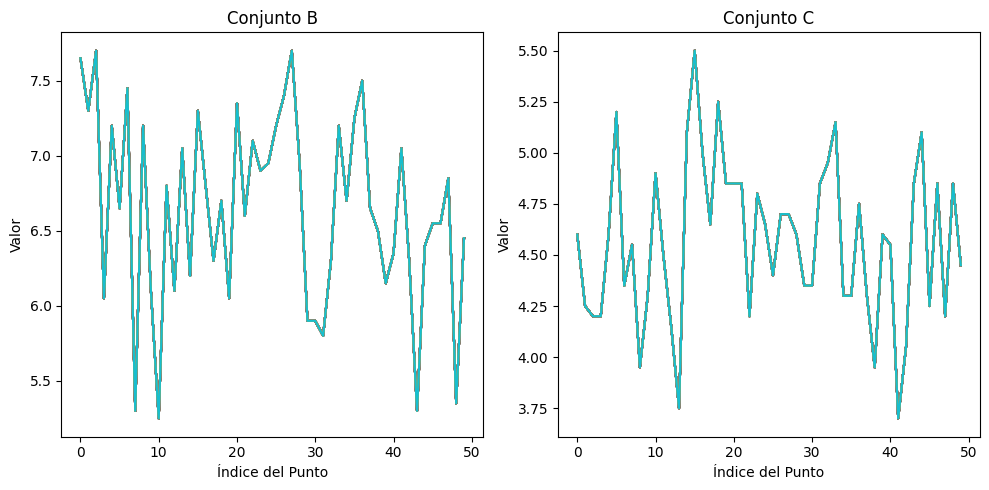

In [26]:
w = x[:-1]  
beta = x[-1] 
A = C_mat
B = A_mat

# Calcula ATw - e y BTw - e
e = np.ones(A.shape[0])
ATw_minus_e = A.dot(w) - e * beta

e = np.ones(B.shape[0])
BTw_minus_e = B.dot(w) - e * beta

# Graficación
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ATw_minus_e, label='ATw - e')
plt.title('Conjunto B')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor')
#plt.legend()

plt.subplot(1, 2, 2)
plt.plot(BTw_minus_e, label='BTw - e')
plt.title('Conjunto C')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor')
#plt.legend()

plt.tight_layout()
plt.show()

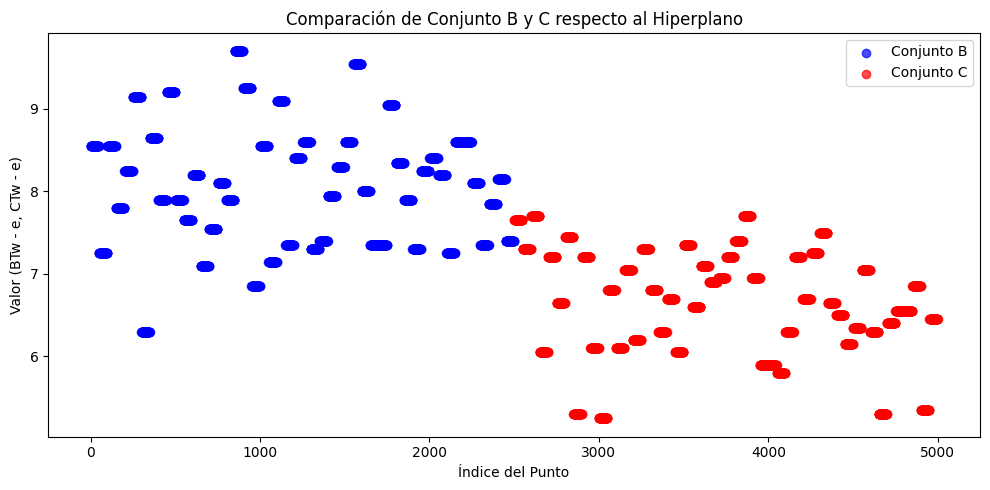

In [27]:
w = x[:-1]  
beta = x[-1] 
A = B_mat
B = C_mat

# Calcula ATw - e y BTw - e
e_A = np.ones(A.shape[0])
ATw_minus_e = A.dot(w) - e_A * beta

e_B = np.ones(B.shape[0])
BTw_minus_e = B.dot(w) - e_B * beta

# Asegurémonos de que las dimensiones de ATw_minus_e y BTw_minus_e son adecuadas para graficar
# Por claridad, vamos a aplanar los arrays para garantizar que son 1D
ATw_minus_e = ATw_minus_e.flatten()
BTw_minus_e = BTw_minus_e.flatten()

# Graficación en una sola gráfica usando scatter
plt.figure(figsize=(10, 5))

# Aquí no necesitamos generar índices ya que scatter puede manejar los valores directamente
plt.scatter(np.arange(len(ATw_minus_e)), ATw_minus_e, color='blue', label='Conjunto B', alpha=0.7)
plt.scatter(np.arange(len(BTw_minus_e)) + len(ATw_minus_e), BTw_minus_e, color='red', label='Conjunto C', alpha=0.7)

plt.title('Comparación de Conjunto B y C respecto al Hiperplano')
plt.xlabel('Índice del Punto')
plt.ylabel('Valor (BTw - e, CTw - e)')
plt.legend()

plt.tight_layout()
plt.show()

#### Visualización del conjunto

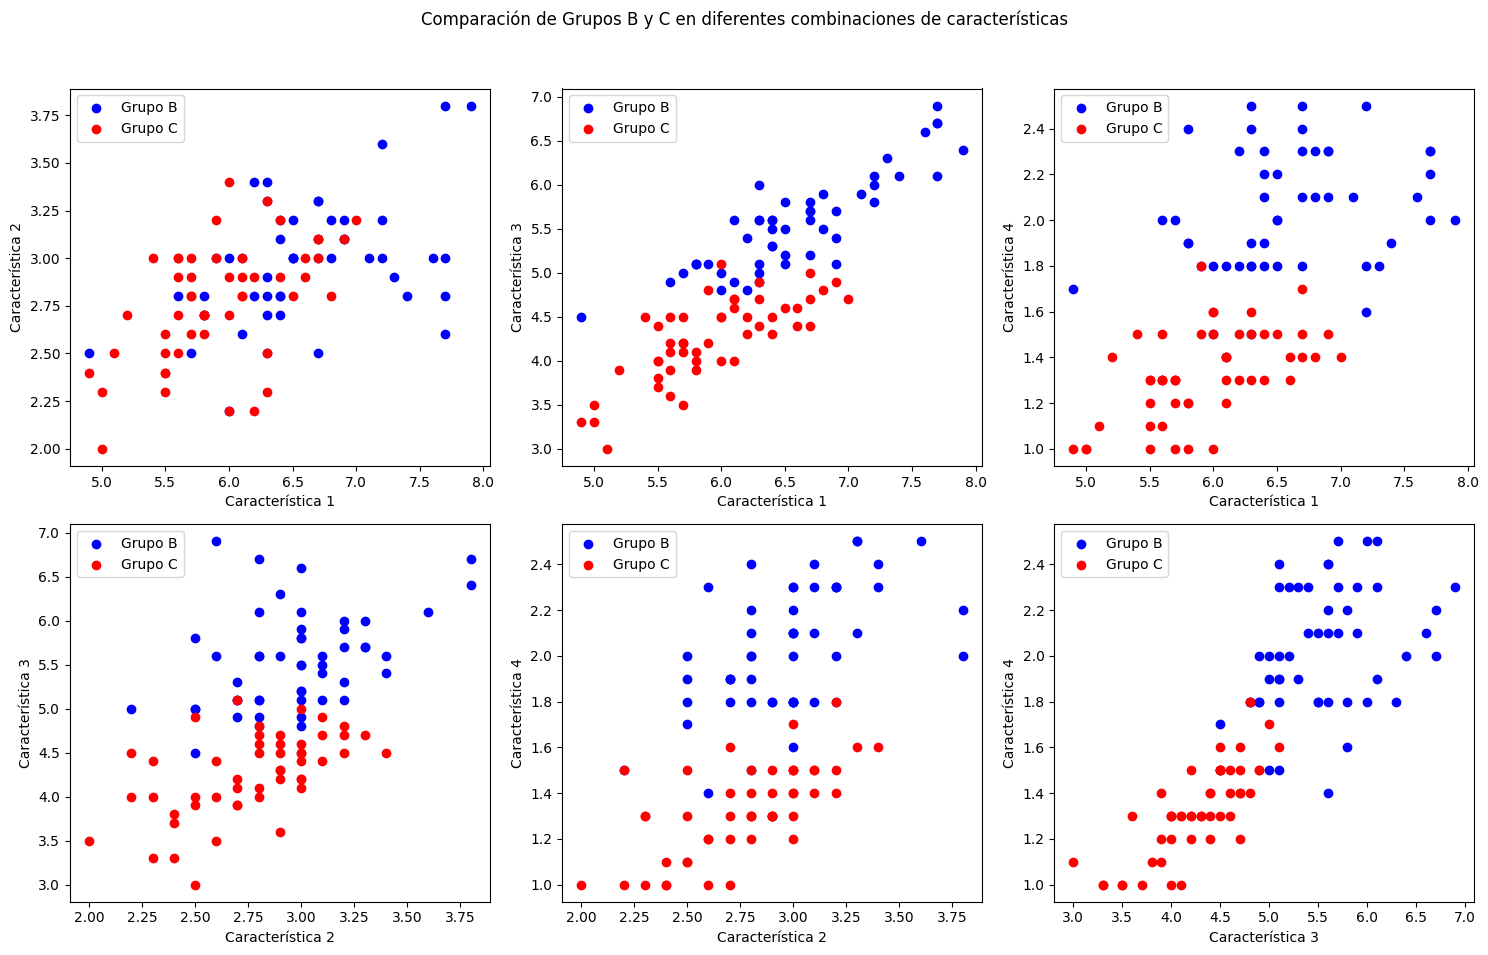

In [28]:
A = B_mat
B = C_mat

w = x[:-1]  
beta = x[-1] 


# Definir las combinaciones de características
combinaciones = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Crear una figura y ejes para las subgráficas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Comparación de Grupos B y C en diferentes combinaciones de características')

for i, (feat1, feat2) in enumerate(combinaciones):
    ax = axes[i//3, i%3]
    # Graficar los puntos de A y B para cada combinación de características
    ax.scatter(A[:, feat1], A[:, feat2], color='blue', label='Grupo B')
    ax.scatter(B[:, feat1], B[:, feat2], color='red', label='Grupo C')
    ax.set_xlabel(f'Característica {feat1+1}')
    ax.set_ylabel(f'Característica {feat2+1}')
    ax.legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

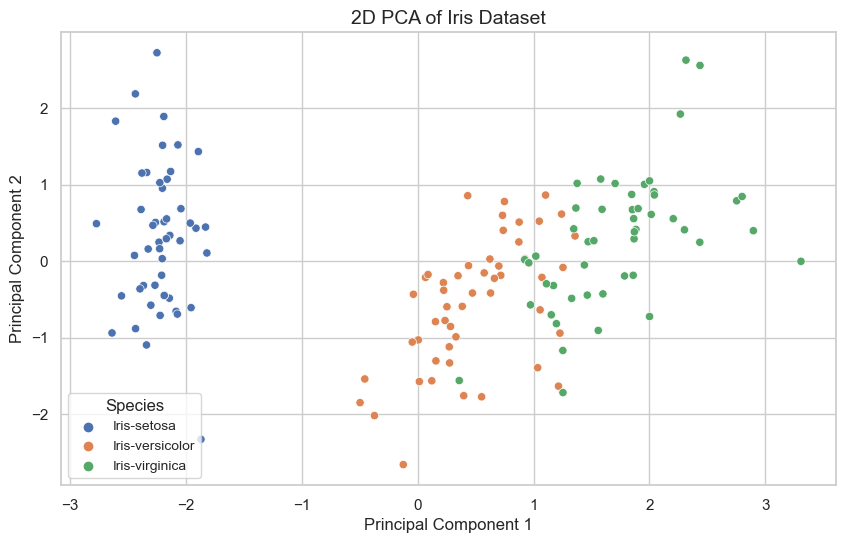

In [81]:
#Aplicamos PCA a 2 dimensiones.
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = iris.loc[:, features].values
y = iris.loc[:,['Species']].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

finalDf = pd.concat([principalDf, iris[['Species']]], axis = 1)
df = finalDf

# Visualización
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(10, 6), dpi=100)
sns.scatterplot(x='PCA1', y='PCA2', hue='Species', data=finalDf, palette="deep")
plt.title('2D PCA of Iris Dataset', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Species', fontsize=10)
plt.show()

In [59]:
df.head()

,PCA1,PCA2,Species
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa
3,-2.304197,-0.575368,Iris-setosa
4,-2.388777,0.674767,Iris-setosa


In [60]:
# Conjunto A tiene a 'Iris-setosa'
conjunto_A = df[df['Species'] == 'Iris-setosa']

# Conjunto B tiene a 'Iris-virginica' y 'Iris-versicolor'
conjunto_B = df[(df['Species'] == 'Iris-virginica') | (iris['Species'] == 'Iris-versicolor')]

In [84]:
A_mat = conjunto_A[["PCA1", "PCA2"]].values
B_mat = conjunto_B[["PCA1", "PCA2"]].values

Vec_m1 = np.full((len(conjunto_A), 1), -1)
Vec_1 = np.full((len(conjunto_B), 1), 1)

concatenated_matrix_up = np.hstack((-A_mat, Vec_m1))
concatenated_matrix_down = np.hstack((B_mat, Vec_1))

F = np.vstack((concatenated_matrix_up, concatenated_matrix_down))

# Definiendo Q, c y d para el problema de programación cuadrática
Q = np.eye(F.shape[1])
c = np.full((F.shape[1], 1), 0)
d = np.full((F.shape[0], 1), 1)

In [85]:
(x, mu, z, iteraciones) = myqp_intpoint_modificado(Q, F, c, d)

Iteración: 1 | Norma de cnpo: 229.49413995659117
Iteración: 2 | Norma de cnpo: 167.72510458216004
Iteración: 3 | Norma de cnpo: 87.1231088541734
Iteración: 4 | Norma de cnpo: 32.72646981293837
Iteración: 5 | Norma de cnpo: 6.057645093437496
Iteración: 6 | Norma de cnpo: 0.5312186267398737
Iteración: 7 | Norma de cnpo: 0.2517241175897247
Iteración: 8 | Norma de cnpo: 0.17827213300733374
Iteración: 9 | Norma de cnpo: 0.15068279504822696
Iteración: 10 | Norma de cnpo: 0.07941108848888473
Iteración: 11 | Norma de cnpo: 0.0450292708941705
Iteración: 12 | Norma de cnpo: 0.02366108940215925
Iteración: 13 | Norma de cnpo: 0.012447647281977515
Iteración: 14 | Norma de cnpo: 0.006543269769749809
Iteración: 15 | Norma de cnpo: 0.0034376542681198506
Iteración: 16 | Norma de cnpo: 0.0018054607201246223
Iteración: 17 | Norma de cnpo: 0.0009480604491684206
Iteración: 18 | Norma de cnpo: 0.0004977854827326373
Iteración: 19 | Norma de cnpo: 0.0002613522491174823
Iteración: 20 | Norma de cnpo: 0.0001372

In [86]:
x

array([[ 1.66346772],
       [-0.44821844],
       [ 1.07020995]])

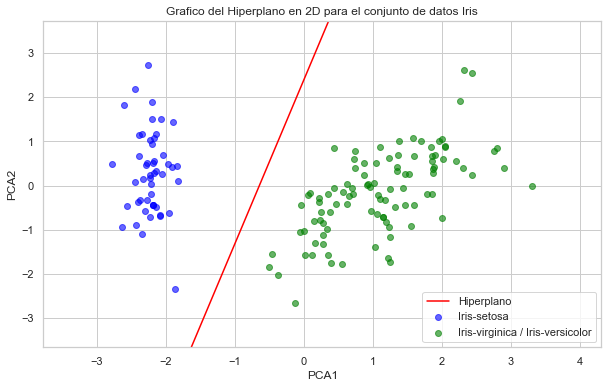

In [88]:
w1 = x[0]
w2 = x[1]
e = x[2]

# Puntos para 'x1' (PCA1)
x1_values = np.linspace(-3, 3, 100)
# Calcular los valores correspondientes de 'x2' (PCA2) usando la fórmula del hiperplano
x2_values = (-w1 / w2) * x1_values - e / w2

# Graficar el hiperplano
plt.figure(figsize=(10, 6))
plt.plot(x1_values, x2_values, label='Hiperplano', color='red')

# Conjunto A: Iris-setosa
conjunto_A = df[df['Species'] == 'Iris-setosa']
x_pca1_A = conjunto_A['PCA1'].values
x_pca2_A = conjunto_A['PCA2'].values

# Conjunto B: Iris-virginica y Iris-versicolor
conjunto_B = df[(df['Species'] == 'Iris-virginica') | (df['Species'] == 'Iris-versicolor')]
x_pca1_B = conjunto_B['PCA1'].values
x_pca2_B = conjunto_B['PCA2'].values

plt.scatter(x_pca1_A, x_pca2_A, c='blue', label='Iris-setosa', alpha=0.6)
plt.scatter(x_pca1_B, x_pca2_B, c='green', label='Iris-virginica / Iris-versicolor', alpha=0.6)


plt.xlim(min(x_pca1_A.min(), x_pca1_B.min()) - 1, max(x_pca1_A.max(), x_pca1_B.max()) + 1)
plt.ylim(min(x_pca2_A.min(), x_pca2_B.min()) - 1, max(x_pca2_A.max(), x_pca2_B.max()) + 1)


# Añadir etiquetas y leyenda
plt.title('Grafico del Hiperplano en 2D para el conjunto de datos Iris')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid(True)
plt.show()